In [1]:
import torch
import snn_utils
import pylab as plt
device = 'cuda'

This is a tutorial for apply a DECOLLE network to a traditional MNIST problem usingwith local errors. The reader is assumed to be familiar with Python and Pytorch. If you need to cite this code, please use <a href="arXiv preprint arXiv:1812.10766">(Kaiser, Mostafa, Neftci, 2019)</a>, bibtex:

### Loading MNIST data as spiketrains

The following function will load the MNIST dataset using torchvision modules. It will download and pre-pre-process the data for faster usage.

In [2]:
gen_train = snn_utils.get_mnist_loader(100, Nparts=100, train=True)
gen_test = snn_utils.get_mnist_loader(100, Nparts=100, train=False)

Because MNIST is an image, we need to transform it into a spiketrain. The function __image2spiketrain__ in snn_utils takes case of this.

In [3]:
datait = iter(gen_train)
raw_input, raw_labels = next(datait)
data, labels1h = snn_utils.image2spiketrain(raw_input, raw_labels, max_duration=1000, gain=20)
data_t = torch.FloatTensor(data)
labels_t = torch.Tensor(labels1h)

Let's examine the shape of data:

In [4]:
data.shape

(1000, 100, 1, 28, 28)

1000 here corresponds to the number of time setps, 100 is the batchsize, 1 is the number of channels and 28,28 are the height and width, respectively. The last three dimensions will be important when we'll use convolutional or locally connected layers, but for the moment, our network has no structure.

Here is what one sample looks like

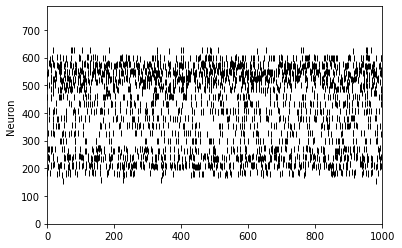

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9b843da0d0>, None)

In [5]:
snn_utils.plotLIF(U=None,S=data_t[:,0].view(1000,-1).data.numpy())

The average reate here is more revealing. Our MNIST input spike trains are simply flattened spiketrains representing the digit image in the firing rates.

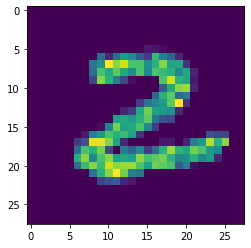

In [6]:
plt.imshow(data_t[:,0].data.numpy().mean(axis=0)[0])

In [7]:
print(labels_t[:,0].argmax(1)[-1])

tensor(2)


Let's create an iterator function that does all these steps:

In [8]:
def iter_mnist(gen_train, batchsize=100, T=1000, max_rate = 20):
    datait = iter(gen_train)
    for raw_input, raw_labels in datait:
        data, labels1h = snn_utils.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate)
        data_t = torch.FloatTensor(data)
        labels_t = torch.Tensor(labels1h)
        yield data_t, labels_t  

### Creating the MNIST Nwtwork

We make use of decolle, a python module contains a cleanly written DECOLLE module based on the principles described in tutorial 1. decolle should have been cloned under lib when you clones this repository. (In git terms, it is a submodule). If the decolle module isn't there run commented cell below

In [14]:
!git submodule update --init decolle_public 
!git submodule foreach git pull origin master

Entering 'decolle_public'
From github.com:nmi-lab/decolle-public
 * branch            master     -> FETCH_HEAD
Already up to date.


In [15]:
import decolle_public.decolle as decolle
from decolle_public.decolle import lenet_decolle_model 

The following creates a three layer DECOLLE network

In [16]:
T = 300 #duration of sequence
data, target = next(iter_mnist(gen_train, T=T))
data = data.to(device)
target = target.to(device)
print(data.shape)

torch.Size([300, 100, 1, 28, 28])


In [17]:
net = lenet_decolle_model.LenetDECOLLE(input_shape = data.shape[2:], Mhid = [150,120], num_conv_layers=0, num_mlp_layers=2, alpha=[.95],beta=[.92], lc_ampl=5., out_channels=10).to(device)

Let's examine the created network

In [18]:
net

LenetDECOLLE(
  (LIF_layers): ModuleList(
    (0): LIFLayer(
      (base_layer): Linear(in_features=784, out_features=150, bias=True)
    )
    (1): LIFLayer(
      (base_layer): Linear(in_features=150, out_features=120, bias=True)
    )
  )
  (readout_layers): ModuleList(
    (0): Linear(in_features=150, out_features=10, bias=True)
    (1): Linear(in_features=120, out_features=10, bias=True)
  )
  (pool_layers): ModuleList(
    (0): Sequential()
    (1): Sequential()
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
  )
)

The network consists in 2 LIF layers, 150 and 120 neurons, with a readout layer and dropout layer associated to each. There are no pool_layers here, therefore they are represented as pass through layers (Sequential()). Dropout modules are used for the readout. Next we set up loss and optimization

In [19]:
loss = torch.nn.SmoothL1Loss()
opt = torch.optim.Adamax(net.get_trainable_parameters(), lr=1e-5, betas=[0., .95])

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        loss_tv += loss(r[i],tgt) 
    return loss_tv

Initialize the DECOLLE network with the correct batch size. To avoid problems with initialization there is a burnin period where the state variables are allowed to settle. There is a little quirk here in that be need to swap the batch dimension and the timing dimension.

In [20]:
net.init(data.transpose(0,1), len(net))

Initialize the parameters

In [21]:
net.init_parameters(data.transpose(0,1))

Train the network

In [ ]:
for e in range(10):        
    for data, label in iter_mnist(gen_train, T=T):
        net.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=100)
        for n in range(T):
            st, rt, ut = net.forward(data_d[n])        
            loss_tv = decolle_loss(rt, st, label_d[n])
            loss_tv.backward()
            opt.step()
            opt.zero_grad()
            loss_hist += loss_tv
    print(e, loss_hist)

## Convolutional DECOLLE

A convolutional DECOLLE network can be obtained by replacing the network generation as follows

In [22]:
convnet = lenet_decolle_model.LenetDECOLLE( out_channels=10,
                    Nhid=[16,32], #Number of convolution channels
                    Mhid=[64],
                    kernel_size=[7],
                    pool_size=[2,2],
                    input_shape=data.shape[2:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=2,
                    num_mlp_layers=1,
                    lc_ampl=.5).to(device)

In [25]:
data, target = next(iter_mnist(gen_train, T=T))
data_d = data.to(device)
target_d = target.to(device)
convnet.init_parameters(data_d.transpose(0,1))

In [26]:
opt_conv = torch.optim.Adamax(convnet.get_trainable_parameters(), lr=1e-8, betas=[0., .95])

Train the network

In [ ]:
for e in range(10):        
    for data, label in iter_mnist(gen_train, T=T):
        convnet.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet.init(data_d.transpose(0,1), 100)
        for n in range(T):
            st, rt, ut = convnet(data_d[n])        
            loss_tv = decolle_loss(rt, st, label_d[n])
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
    print(e, loss_hist)